# SGD and Momentum Example
![intro](./Result.jpg)

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
seed = 42
np.random.seed(42)
matplotlib.rcParams.update({'font.size': 14})

## Data

In [2]:
n_dat = 100
bound = 3
coords_lin = np.linspace(-bound,bound,n_dat)
coords = np.stack(np.meshgrid(coords_lin,coords_lin))
inp = coords.reshape(2,-1).T
true_w = np.array([1,100]).reshape(-1,1)
def f(inp,weights):
    
    return (weights[0]-inp[:,0].reshape(-1,1))**2 + \
            weights[1]*(inp[:,1].reshape(-1,1)-inp[:,0].reshape(-1,1)**2)**2

def f_grad(inp,weights):
    return np.stack([2*(weights[0]-inp[:,0].reshape(-1,1)),
                     (inp[:,1].reshape(-1,1)-inp[:,0].reshape(-1,1)**2)**2]).T

y = f(inp,true_w)

In [3]:
def plot_loss_landscape(inp,true_weights,boundx=140,boundy=500,dx=100,surf=False):
    if boundy is None: boundy=boundx
        
    x = np.linspace(-boundx,boundx,dx)
    y = np.linspace(-boundy,boundy,dx)
    
    truth = f(inp,true_w)
    test_coords = np.stack(np.meshgrid(x,y))
    test_w = test_coords.reshape(2,-1)
    pred = f(inp,test_w)
    loss = (pred-truth)**2
    loss = loss.mean(0)
    if surf:
        ax = plt.subplot(projection='3d')
        ax.plot_surface(*test_coords,loss.reshape(dx,dx))
    else:
        #plt.imshow(loss.reshape(dx,dx),cmap=plt.cm.jet,interpolation='bilinear')
        plt.contourf(x,y,loss.reshape(dx,dx),cmap=plt.cm.Reds)

## Gradient Descent Algorithms

In [4]:
def GD(inp,truth,w_init,lr,steps):
    w_list = [w_init[:,0]]
    grads = []
    losses = []
    w = w_init
    for e in range(steps):
        pred = f(inp,w)
        diff = (pred - truth)
        loss = (0.5*diff**2).mean(0)
        grad = np.mean(0.5*diff*f_grad(inp,w)[0],0)
        w = w - lr*grad.reshape(-1,1)
        w_list.append(w[:,0])
        losses.append(loss)
        
    return np.stack(w_list),grad,losses

def SGD(inp_full,truth_full,w_init,lr,steps,divider):
    w_list = [w_init[:,0]]
    grads = []
    losses = []
    w = w_init
    for e in range(steps):
        idx = np.random.choice(inp_full.shape[0],size=int(inp_full.shape[0]/divider))
        inp, truth = inp_full[idx], truth_full[idx]
        pred = f(inp,w)
        diff = (pred - truth)
        loss = (0.5*diff**2).mean(0)
        grad = np.mean(0.5*diff*f_grad(inp,w)[0],0)
        w = w - lr*grad.reshape(-1,1)
        w_list.append(w[:,0])
        losses.append(loss)
        
    return np.stack(w_list),grads,losses

def MSGD(inp_full,truth_full,w_init,lr,steps,divider,beta = 0.95):
    w_list = [w_init[:,0]]
    grads = []
    losses = []
    w = w_init
    ema = 0.
    
    for e in range(steps):
        idx = np.random.choice(inp_full.shape[0],size=int(inp_full.shape[0]/divider),replace=False)
        inp, truth = inp_full[idx], truth_full[idx]
        pred = f(inp,w)
        diff = (pred - truth)
        loss = (diff**2).mean(0)
        grad = np.mean(0.5*diff*f_grad(inp,w)[0],0)
        
        ema = beta * ema + (1-beta)*grad.reshape(-1,1)
        
        w = w - lr*ema
        w_list.append(w[:,0])
        losses.append(loss)
        
    return np.stack(w_list),grads,losses

## Example

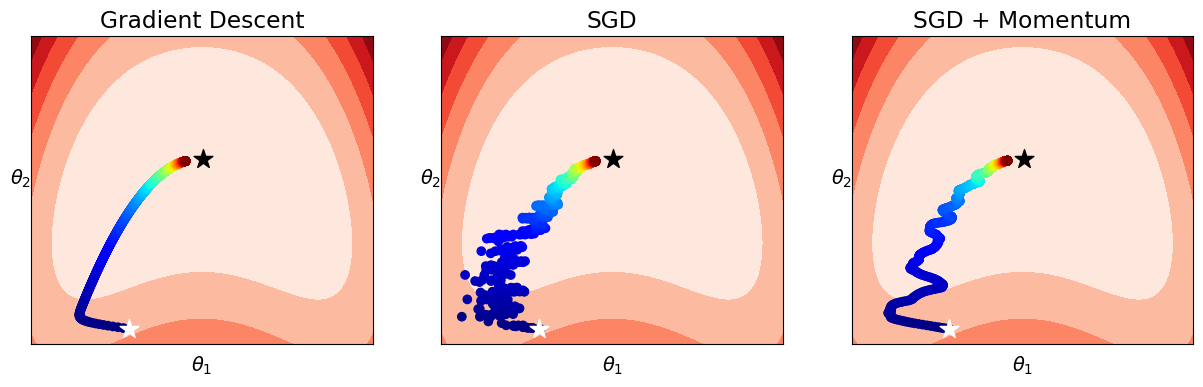

In [5]:
steps = 1500
divider = int(inp.shape[0]/2)
lr = 1e-5
w_init=np.array([-60,-450]).reshape(-1,1)
w_GD, grad, losses = GD(inp,y,w_init,lr,steps)
w_SGD, grad, losses_SGD = SGD(inp,y,w_init,lr,steps,divider)
w_MSGD, grad, losses_MSGD = MSGD(inp,y,w_init,lr,steps,divider,beta=0.95)

fig,(ax1,ax2,ax3) = plt.subplots(ncols=3,figsize=(15,4))
plt.sca(ax1)
plot_loss_landscape(inp,true_w)
plt.scatter(*w_GD.T,c=np.arange(w_GD.shape[0]),cmap=plt.cm.jet)
plt.scatter(*true_w,marker='*',s= 200,color='black')
plt.scatter(*w_init,marker='*',s= 200,color='white')
plt.xticks([]); plt.yticks([]); plt.title('Gradient Descent')
plt.xlabel(r'$\theta_1$'); plt.ylabel(r'$\theta_2$',rotation=0)

plt.sca(ax2)
plot_loss_landscape(inp,true_w)
plt.scatter(*w_SGD.T,c=np.arange(w_SGD.shape[0]),cmap=plt.cm.jet)
plt.scatter(*true_w,marker='*',s= 200,color='black')
plt.scatter(*w_init,marker='*',s= 200,color='white')
plt.xticks([]); plt.yticks([]); plt.title('SGD')
plt.xlabel(r'$\theta_1$'); plt.ylabel(r'$\theta_2$',rotation=0)

plt.sca(ax3)
plot_loss_landscape(inp,true_w)
plt.scatter(*w_MSGD.T,c=np.arange(w_MSGD.shape[0]),cmap=plt.cm.jet)
plt.scatter(*true_w,marker='*',s= 200,color='black')
plt.scatter(*w_init,marker='*',s= 200,color='white')
plt.xticks([]); plt.yticks([]); plt.title('SGD + Momentum')
plt.xlabel(r'$\theta_1$'); plt.ylabel(r'$\theta_2$',rotation=0)
plt.savefig('Result.jpg',bbox_inches='tight',dpi=140)

## Creating ReadMe

In [ ]:
%%javascript
IPython.notebook.save_notebook()

In [ ]:
os.system('rm SGD_files/*')
os.system('jupyter nbconvert --to markdown SGD.ipynb')
os.system('mv SGD.md README.md')
os.system('git add SGD_files/')